# Environmental Setup


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
import os
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import Model
import pandas as pd
import time
import glob
from tqdm import tqdm

# Data Loading and Preprocessing

We are loading the MNIST dataset and preprocess it. Since many pretrained models require 3-channel RGB images (and MNIST is grayscale), we convert our images from shape (28, 28, 1) to (28, 28, 3) by repeating the single channel.

In [2]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize images to [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Expand dims to add channel dimension (28,28,1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Convert grayscale to RGB by repeating the channel
x_train = np.repeat(x_train, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (60000, 28, 28, 3)
x_test shape: (10000, 28, 28, 3)


- **Training set (x_train)**: *60,000* images with dimensions 28x28x3.​
- **Test set (x_test)**: *10,000* images with dimensions 28x28x3.
- **28x28:** Each image is 28 pixels in height and 28 pixels in width.​
- **3 Channels:** Although the original MNIST images are grayscale (1 channel), they've been expanded to 3 channels to be compatible with models expecting RGB input.

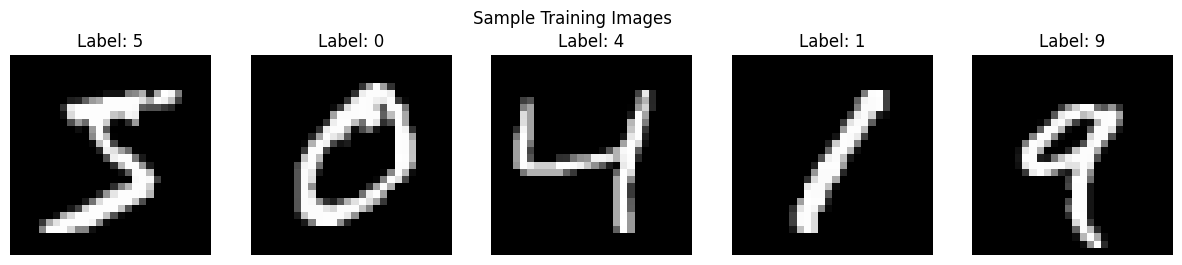

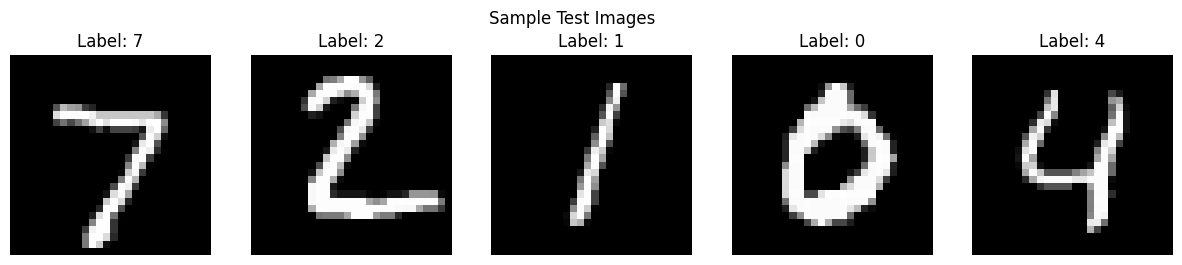

In [3]:
# Function to display images

def display_images(images, labels, title, num_images=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display first 5 training images
display_images(x_train, y_train, "Sample Training Images")
# Display first 5 test images
display_images(x_test, y_test, "Sample Test Images")

# Model Architecture

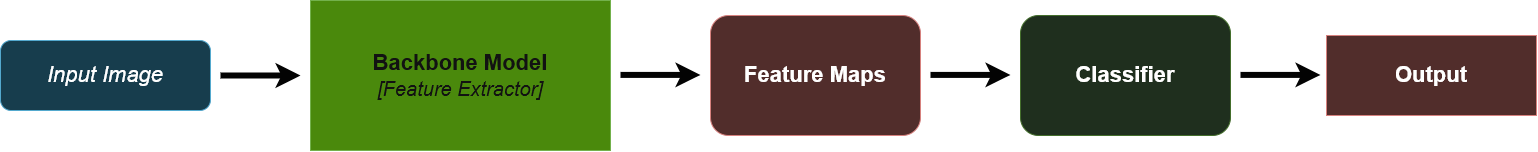

In [4]:
from IPython.display import Image, display
image_path = r'E:\Source Codes\AIML\final_year_paper\xai_research_project\visualizations\architecture-1.png'
display(Image(filename=image_path))

### The architecture consists of several modular components:

**Input:** The images are in RGB format with a resolution of 28x28 pixels (even though MNIST is naturally grayscale, they have been expanded to 3 channels for compatibility with many pretrained networks). They serve as the raw data fed into the network.

**Backbone (Feature Extractor):** The backbone is a CNN that extracts feature representations (edges, curves, shapes) from the input images. Models like ResNet, MobileNet, VGG, DenseNet, etc. It is the core component that transforms the raw pixel data into high-dimensional feature maps.

**Feature Maps:** These are the intermediate outputs from the backbone. They encapsulate various levels of abstraction:
    - Early layers capture low-level features (e.g., edges, corners).
    - Later layers capture high-level features (e.g., shapes corresponding to digit curves).
Feature maps provide the rich representations that your subsequent layers (e.g., attention and classification layers) will work on.

**Classifier:** A series of fully connected (dense) layers that take the flattened feature maps and produce class scores. They convert the learned features into probabilities for each digit class using a final softmax layer. Typically includes a dense layer with a ReLU activation before the final softmax.

**Output:** A softmax output layer that yields a probability distribution over the 10 digit classes. It gives the final prediction with confidence scores for every class, which is essential for classification tasks.

# Baseline Model

We first build a simple CNN architecture with three parts:
- **Input:** Receives MNIST images (after conversion).
- **Backbone:** A stack of convolutional layers that extract feature maps.
- **Output:** A classifier (using fully connected layers) for 10 digit classes

The baseline CNN acts as the *initial reference* architecture — a **controllable environment** to:
> Observe how features evolve across layers (feature maps)

> Measure accuracy, training stability, and loss behavior

> Later compare with deeper or pretrained backbones

In [5]:
# Define the input
inputs = Input(shape=(28, 28, 3), name='input_image')

# Backbone CNN
x = Conv2D(32, (3, 3), activation='relu', name='conv1')(inputs)
x = MaxPooling2D((2, 2), name='pool1')(x)

x = Conv2D(64, (3, 3), activation='relu', name='conv2')(x)
x = MaxPooling2D((2, 2), name='pool2')(x)

# Feature Maps before Flattening (for later analysis)
feature_maps = x

x = Flatten(name='flatten')(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dropout(0.5, name='dropout')(x)

# Output layer
outputs = Dense(10, activation='softmax', name='output')(x)

# Create the model
baseline_model = Model(inputs=inputs, outputs=outputs)
baseline_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Summary
baseline_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape               ┃        Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)           │ (None, 28, 28, 3)          │              0 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ conv1 (Conv2D)                     │ (None, 26, 26, 32)         │            896 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ pool1 (MaxPooling2D)               │ (None, 13, 13, 32)         │              0 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ conv2 (Conv2D)                     │ (None, 11, 11, 64)         │         18,496 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ pool2 (MaxPooling2D)               │ (None, 5, 5, 64)           │              0 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ flatten (Flatten)                  │ (None, 1600)               │              0 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ fc1 (Dense)                        │ (None, 128)                │        204,928 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dropout (Dropout)                  │ (None, 128)                │              0 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ output (Dense)                     │ (None, 10)                 │          1,290 │
└────────────────────────────────────┴────────────────────────────┴────────────────┘

 Total params: 225,610 (881.29 KB)

 Trainable params: 225,610 (881.29 KB)

 Non-trainable params: 0 (0.00 B)

### Breakdown:

**Input Layer** (input_image): The model accepts batches of images where each image is *28x28* pixels with *3 channels* (RGB). The None represents the batch size, meaning it can vary.

**Conv1** (Conv2D): The output spatial dimension drops from *28×28* to *26×26* due to the convolution operation **without padding**.
Total parameters are computed based on `(filter_height × filter_width × input_channels + bias)` for each filter.

**Pool1** (MaxPooling2D): MaxPooling with a pool size of *2x2* downsamples the feature maps, reducing the spatial dimensions by a *factor of 2* (from 26×26 to 13×13).

**Conv2** (Conv2D):  This layer applies *64 filters*, again of *size 3x3*.
With valid convolution (no padding), the *spatial dimensions* further reduce from *13×13* to *11×11*.
The number of parameters increases as the number of input channels is now *32* (from the previous layer), and each filter now has more weights.

**Pool2** (MaxPooling2D): Another **downsampling** with a *2x2* pool reduces the *11×11* feature maps to roughly *5×5* (depending on the stride/padding details).

**Flatten**: This layer converts the 3D feature maps `(5×5×64 = 1600 values per image)` into a 1D vector for the dense (fully connected) layers.

**FC1** (Dense): A fully connected layer with *128 neurons* that learns high-level representations.
It connects to all 1600 inputs from the previous layer, hence the number of weights is high.

**Dropout**: Regularization technique that randomly sets a fraction of the inputs to zero during training to prevent overfitting. It doesn’t add any additional parameters.

**Output** (Dense): This final layer maps the *128-dimensional* input to *10 classes* (digits 0-9).
A softmax activation (assumed from context) is applied to produce class probabilities.

In [6]:
# Training the Baseline Model

history = baseline_model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(x_test, y_test)
)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.8583 - loss: 0.4484 - val_accuracy: 0.9840 - val_loss: 0.0469
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - accuracy: 0.9746 - loss: 0.0836 - val_accuracy: 0.9888 - val_loss: 0.0350
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - accuracy: 0.9819 - loss: 0.0605 - val_accuracy: 0.9885 - val_loss: 0.0330
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.9850 - loss: 0.0486 - val_accuracy: 0.9911 - val_loss: 0.0264
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.9885 - loss: 0.0377 - val_accuracy: 0.9914 - val_loss: 0.0269


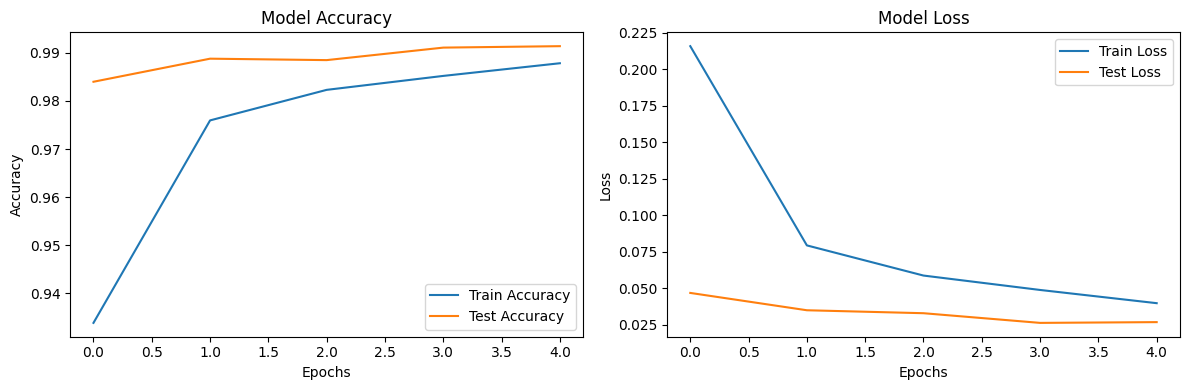

In [7]:
# Evaluate Accuracy & Stability

# Plot accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [8]:
# Create a model that outputs intermediate layers

feature_map_model = Model(inputs=baseline_model.input,
                          outputs=baseline_model.get_layer('conv1').output)

# Choose a test image
test_image = x_test[0:1]  # shape: (1, 28, 28, 3)

# Predict feature maps
feature_maps = feature_map_model.predict(test_image)
print("Feature map shape:", feature_maps.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Feature map shape: (1, 26, 26, 32)


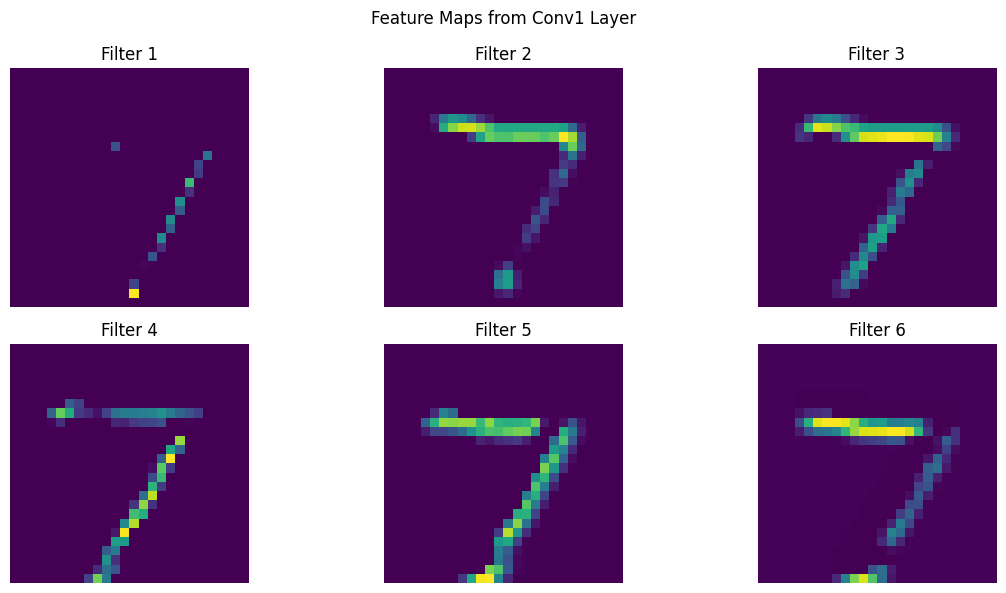

The images show a visualizations of several of feature maps. These maps help understand which features (such as edges or textures) the network is detecting in the early stages of processing.


In [9]:
# Plot the first 6 feature maps

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
    plt.title(f'Filter {i+1}')
    plt.axis('off')
plt.suptitle('Feature Maps from Conv1 Layer')
plt.tight_layout()
plt.show()

print("The images show a visualizations of several of feature maps. These maps help understand which features (such as edges or textures) the network is detecting in the early stages of processing.")

In [10]:
# Evaluation on Test Data

test_loss, test_acc = baseline_model.evaluate(x_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

313/313 - 1s - 4ms/step - accuracy: 0.9914 - loss: 0.0269

Test Accuracy: 0.9914
Test Loss: 0.0269


**Accuracy:** `99.10%` — Extremely high accuracy on the test set, indicating that the model generalizes well to unseen data. <br>
**Loss:** `0.0256` — A low loss value, which suggests that the model's predictions are close to the true labels.

**Interpretation:** This performance reinforces that the baseline model is very effective on MNIST, providing a robust starting point for further experimentation with more complex backbones, attention mechanisms, or optimizers.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


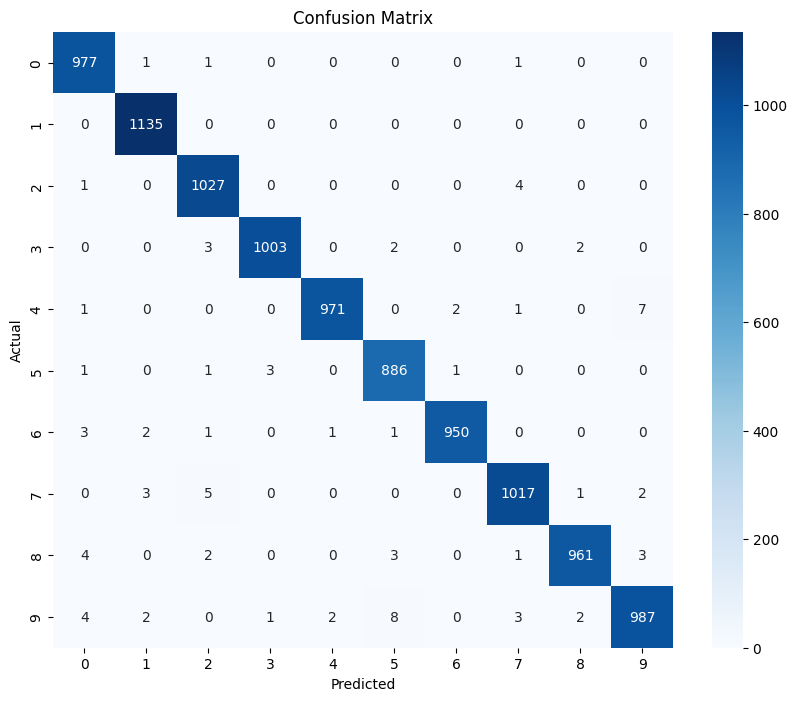

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [11]:
# Confusion Matric on Baseline Metrices

y_pred = np.argmax(baseline_model.predict(x_test), axis=1)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

### Analysis:

**Per-Class Metrics:**
- **Precision:** The ratio of correctly predicted positive observations to the total predicted positives. Values around 0.98 to 1.00 across classes indicate minimal false positives.
- **Recall:** The ratio of correctly predicted positive observations to all observations in the actual class. High recall (close to 1.00) suggests that nearly all actual digits are correctly detected.
- **F1-Score:** The weighted harmonic mean of precision and recall. Values around 0.99 indicate an excellent balance between precision and recall.
- **Support:** The number of true instances for each digit in the test set (e.g., 980 for digit 0, 1135 for digit 1, etc.).

### Overall Averages:

**Accuracy:** `99%` across the entire test set. <br>
**Macro and Weighted Averages:** Consistently high values indicate that the model performs uniformly across all classes.

# Experimenting on different Backbones

## Preparing the Dataset

Since many of the backbones expect *larger* input images `(often 224×224 or 96×96)`, you will first need to **resize** the MNIST images. We’ll write a helper function for that.

**Resize the MNIST images** from *28×28×3* to the required size (we’ll later use different target sizes depending on the backbone—but for simplicity, here we use one common size, e.g. *224×224*, which works for many models)

In [5]:
# Load the MNIST Dataset and make a dataframe with a subset of images

np.random.seed(42)
tf.random.set_seed(42)

# Load MNIST data
(x_train_full, y_train_full), (x_test_full, y_test_full) = tf.keras.datasets.mnist.load_data()

# Normalize images to [0,1] and expand dims to add channel, then convert grayscale to 3-channel RGB
x_train = np.expand_dims(x_train_full.astype('float32') / 255., -1)
x_test  = np.expand_dims(x_test_full.astype('float32') / 255., -1)
x_train = np.repeat(x_train, 3, axis=-1)
x_test  = np.repeat(x_test, 3, axis=-1)

print("Original x_train shape:", x_train.shape)
print("Original x_test shape:", x_test.shape)

# Reduce dataset size to 20%
fraction = 0.20
num_train = int(x_train.shape[0] * fraction)
num_test  = int(x_test.shape[0] * fraction)

train_indices = np.random.choice(x_train.shape[0], num_train, replace=False)
test_indices  = np.random.choice(x_test.shape[0], num_test, replace=False)

x_train_subset = x_train[train_indices]
y_train_subset = y_train_full[train_indices]
x_test_subset  = x_test[test_indices]
y_test_subset  = y_test_full[test_indices]

print("Reduced x_train shape:", x_train_subset.shape)
print("Reduced x_test shape:", x_test_subset.shape)

Original x_train shape: (60000, 28, 28, 3)
Original x_test shape: (10000, 28, 28, 3)
Reduced x_train shape: (12000, 28, 28, 3)
Reduced x_test shape: (2000, 28, 28, 3)


In [6]:
# Resize MNIST Images to 244 x 244

TARGET_SIZE = (224, 224)

def save_images(images, labels, base_dir, subset='train'):
    os.makedirs(base_dir, exist_ok=True)
    # Create folder for each class (0-9)
    for i in range(10):
        class_dir = os.path.join(base_dir, str(i))
        os.makedirs(class_dir, exist_ok=True)

    for idx, (img, label) in enumerate(zip(images, labels)):
        img_resized = cv2.resize(img, TARGET_SIZE)
        filename = os.path.join(base_dir, str(label), f'{subset}_{idx}.png')
        cv2.imwrite(filename, (img_resized * 255).astype(np.uint8))

    print(f"{subset.capitalize()} images saved to {base_dir}")

save_images(x_train_subset, y_train_subset, base_dir='mnist_resized/train', subset='train')
save_images(x_test_subset, y_test_subset, base_dir='mnist_resized/test', subset='test')

Train images saved to mnist_resized/train
Test images saved to mnist_resized/test


In [7]:
# Create datasets using image_dataset_from_directory

batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'mnist_resized/train',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=TARGET_SIZE,
    shuffle=True,
    seed=42
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'mnist_resized/test',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=TARGET_SIZE,
    shuffle=False
)

# Optimize data pipeline (caching and prefetching)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 12000 files belonging to 10 classes.
Found 2000 files belonging to 10 classes.


## Testing Backbones

**Backbones** are pretrained *feature extractors—typically* **Convolutional Neural Networks** (CNNs) — that have already learned how to "see".

- Raw pixels don’t mean much. Backbones convert raw images into structured, meaningful representations, capturing Edges, corners, shapes, textures, etc.

- Most backbones are trained on ImageNet (1.2 million images, 1,000 classes). That gives them a robust understanding of visual patterns, ability to generalize to new tasks.

**In our Case (MNIST on Backbones):**
We're not using backbones just to classify digits. You’re:

- Comparing architectures for efficiency and transferability
- Testing how large-scale learned features adapt to simple but shifted tasks
- Prepping for XAI (explainability) and future attention integration

In [15]:
"""
from tensorflow.keras.applications import (
    VGG16, VGG19,
    ResNet50, ResNet101,
    InceptionV3, Xception,
    DenseNet121, DenseNet169,
    MobileNet, MobileNetV2,
    EfficientNetB0, EfficientNetB1,
    NASNetMobile
)

model_list = {
    "VGG16": VGG16,
    "VGG19": VGG19,
    "ResNet50": ResNet50,
    "ResNet101": ResNet101,
    "InceptionV3": InceptionV3,
    "Xception": Xception,
    "DenseNet121": DenseNet121,
    "DenseNet169": DenseNet169,
    "MobileNet": MobileNet,
    "MobileNetV2": MobileNetV2,
    "EfficientNetB0": EfficientNetB0,
    "EfficientNetB1": EfficientNetB1,
    "NASNetMobile": NASNetMobile,
}

In [16]:
"""
def train_model(model_name, base_model_fn, train_ds, test_ds, img_size=(224, 224)):
    tf.keras.backend.clear_session()
    print(f"\nTraining model: {model_name}")

    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
    base_model.trainable = False  # Freeze backbone

    inputs = tf.keras.Input(shape=(img_size[0], img_size[1], 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    start = time.time()
    history = model.fit(train_ds, validation_data=test_ds, epochs=5, verbose=1)
    duration = time.time() - start

    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

    return {
        'Model': model_name,
        'Test Accuracy': round(test_accuracy * 100, 2),
        'Test Loss': round(test_loss, 4),
        'Train Time (s)': round(duration, 2),
        'Params': model.count_params()
    }

In [17]:
"""
results = []

for model_name, model_fn in tqdm(model_list.items()):
    try:
        result = train_model(model_name, model_fn, train_ds, test_ds)
        results.append(result)
    except Exception as e:
        print(f"Error training {model_name}: {e}")
        results.append({
            'Model': model_name,
            'Test Accuracy': None,
            'Test Loss': None,
            'Train Time (s)': None,
            'Params': None
        })

df_results = pd.DataFrame(results)
df_results.to_csv("backbone_model_comparison.csv", index=False)
df_results.sort_values(by="Test Accuracy", ascending=False)

  0%|                                                           | 0/13 [00:00<?, ?it/s]



Training model: VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step
Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6001 - loss: 1.5655Error training VGG16: Graph execution error:

Detected at node StatefulPartitionedCall/functional_1/vgg16_1/block4_conv2_1/Relu defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_ops.cc:1112
	 [[{{node StatefulPartitionedCall/functional_1/vgg16_1/block4_conv2_1/Relu}}]] [Op:__inference_multi_step_on_iterator_59695]


  8%|███▌                                          | 1/13 [53:24<10:40:51, 3204.27s/it]


Training model: VGG19
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step
Epoch 1/5
 66/375 ━━━━━━━━━━━━━━━━━━━━ 42:47 8s/step - accuracy: 0.3106 - loss: 3.8376

 15%|██████▉                                      | 2/13 [1:03:15<5:05:41, 1667.44s/it]

Error training VGG19: Graph execution error:

Detected at node StatefulPartitionedCall/functional_1/vgg19_1/block3_conv4_1/Relu defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_ops.cc:1112
	 [[{{node StatefulPartitionedCall/functional_1/vgg19_1/block3_conv4_1/Relu}}]] [Op:__inference_multi_step_on_iterator_62050]

Training model: ResNet50
Epoch 1/5
  6/375 ━━━━━━━━━━━━━━━━━━━━ 22:24 4s/step - accuracy: 0.1266 - loss: 3.1286

 15%|██████▉                                      | 2/13 [1:03:53<5:51:21, 1916.54s/it]


KeyboardInterrupt: 

## About the Backbones

---

### **VGG16 / VGG19**
- **Year:** 2014  
- **Depth:** 16 / 19 layers  
- **Style:** Deep but simple – stacks of 3×3 convolutions and max-pooling  
- **Pros:**  
  - Easy to understand and modify  
  - Consistent feature sizes  
- **Cons:**  
  - **Massive number of parameters (~138M)**  
  - No parameter sharing or optimization tricks  
- **Use case:** Good for interpretability and classical transfer learning

---

### **ResNet50 / ResNet101**
- **Year:** 2015  
- **Key idea:** **Residual connections** to combat vanishing gradients  
- **ResNet50:** 50 layers, ResNet101: 101 layers  
- **Pros:**  
  - Deep **but efficient**  
  - Good for fine-tuning  
- **Cons:**  
  - Slightly heavier than newer models  
- **Use case:** Very strong general-purpose backbone. **Industry standard.**

---

### **InceptionV3**
- **Year:** 2015 (Google)  
- **Key idea:** Use **multiple filter sizes** in parallel – called “Inception modules”  
- **Pros:**  
  - Computationally efficient  
  - High performance for relatively fewer params  
- **Cons:**  
  - Complex architecture (harder to modify)  
- **Use case:** Efficient feature extraction for tasks that care about scale invariance

---

### **Xception**
- **Year:** 2017  
- **Key idea:** **Depthwise separable convolutions**  
- **Pros:**  
  - Lightweight and accurate  
  - Inspired MobileNet  
- **Cons:**  
  - Requires modern hardware (depthwise ops)  
- **Use case:** A cleaner Inception, good for real-time and edge applications

---

### **DenseNet121 / DenseNet169**
- **Year:** 2017  
- **Key idea:** Each layer gets input from **all previous layers**  
- **Pros:**  
  - Strong gradient flow  
  - Fewer parameters than ResNet for same accuracy  
- **Cons:**  
  - Complex to implement  
- **Use case:** Best for tasks needing high detail retention

---

### **MobileNet / MobileNetV2**
- **Year:** 2017 / 2018  
- **Key idea:** **Depthwise separable convolutions**  
- **Pros:**  
  - Extremely lightweight  
  - Perfect for mobile or embedded systems  
- **Cons:**  
  - Slightly worse accuracy on big tasks  
- **Use case:** Fast inference when hardware is limited

---

### **EfficientNetB0 / B1**
- **Year:** 2019  
- **Key idea:** **Compound scaling** – balance depth, width, and resolution  
- **Pros:**  
  - **State-of-the-art efficiency**  
  - Excellent accuracy-speed tradeoff  
- **Cons:**  
  - Slightly more complex to fine-tune  
- **Use case:** Anytime you want high performance with minimal compute cost

---

## Training the Backbones

In [ ]:
def train_model(model_name, base_model_fn, train_ds, test_ds, img_size=(224,224)):
    # clear previous model & session to free memory
    # tf.keras.backend.clear_session()
    # gc.collect()

    print(f"\n⏳ Training model: {model_name}")
    start = time.time()

    # Build backbone
    base = base_model_fn(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size[0], img_size[1], 3)
    )
    base.trainable = False

    inp = Input(shape=(img_size[0], img_size[1], 3))
    x = base(inp, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(10, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # fit for 5 epochs
    history = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=5,
        verbose=1
    )
    duration = time.time() - start

    # final test eval
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)

    # grab last‐epoch metrics
    ht = history.history
    return {
      'Model': model_name,
      'Params': model.count_params(),
      'Train Time (s)': round(duration,2),
      'Final Train Acc (%)': round(ht['accuracy'][-1]*100,2),
      'Final Val Acc (%)':   round(ht['val_accuracy'][-1]*100,2),
      'Final Train Loss':    round(ht['loss'][-1],4),
      'Final Val Loss':      round(ht['val_loss'][-1],4),
      'Test Acc (%)':        round(test_acc*100,2),
      'Test Loss':           round(test_loss,4)
    }

def append_result_to_csv(result, csv_path='backbone_comparison.csv'):
    """Create or append a single‐row result dict to csv."""
    df = pd.DataFrame([result])
    if not os.path.exists(csv_path):
        df.to_csv(csv_path, index=False)
    else:
        df_existing = pd.read_csv(csv_path)
        pd.concat([df_existing, df], ignore_index=True) \
          .to_csv(csv_path, index=False)
    print(f"✅ Appended results for {result['Model']} to {csv_path}")

In [ ]:
from tensorflow.keras.applications import VGG16

# Pick your model
model_name = "VGG16"
model_fn   = VGG16

# Train & collect Metrics
result = train_model(model_name, model_fn, train_ds, test_ds)

# Append to the master CSV
append_result_to_csv(result)

# Inspect just‐appended row
import pandas as pd
print( pd.read_csv('backbone_comparison.csv').tail(1) )

In [ ]:
from tensorflow.keras.applications import VGG19

# Pick your model
model_name = "VGG19"
model_fn   = VGG19

# Train & collect Metrics
result = train_model(model_name, model_fn, train_ds, test_ds)

# Append to the master CSV
append_result_to_csv(result)

# Inspect just‐appended row
import pandas as pd
print( pd.read_csv('backbone_comparison.csv').tail(1) )

In [ ]:
from tensorflow.keras.applications import ResNet50

# Pick your model
model_name = "ResNet50"
model_fn   = ResNet50

# Train & collect Metrics
result = train_model(model_name, model_fn, train_ds, test_ds)

# Append to the master CSV
append_result_to_csv(result)

# Inspect just‐appended row
import pandas as pd
print( pd.read_csv('backbone_comparison.csv').tail(1) )

In [ ]:
from tensorflow.keras.applications import ResNet101

# Pick your model
model_name = "ResNet101"
model_fn   = ResNet101

# Train & collect Metrics
result = train_model(model_name, model_fn, train_ds, test_ds)

# Append to the master CSV
append_result_to_csv(result)

# Inspect just‐appended row
import pandas as pd
print( pd.read_csv('backbone_comparison.csv').tail(1) )

In [ ]:
from tensorflow.keras.applications import InceptionV3

# Pick your model
model_name = "InceptionV3"
model_fn   = InceptionV3

# Train & collect Metrics
result = train_model(model_name, model_fn, train_ds, test_ds)

# Append to the master CSV
append_result_to_csv(result)

# Inspect just‐appended row
import pandas as pd
print( pd.read_csv('backbone_comparison.csv').tail(1) )

In [ ]:
from tensorflow.keras.applications import Xception

# Pick your model
model_name = "Xception"
model_fn   = Xception

# Train & collect Metrics
result = train_model(model_name, model_fn, train_ds, test_ds)

# Append to the master CSV
append_result_to_csv(result)

# Inspect just‐appended row
import pandas as pd
print( pd.read_csv('backbone_comparison.csv').tail(1) )

In [ ]:
from tensorflow.keras.applications import DenseNet121

# Pick your model
model_name = "DenseNet121"
model_fn   = DenseNet121

# Train & collect Metrics
result = train_model(model_name, model_fn, train_ds, test_ds)

# Append to the master CSV
append_result_to_csv(result)

# Inspect just‐appended row
import pandas as pd
print( pd.read_csv('backbone_comparison.csv').tail(1) )

In [ ]:
from tensorflow.keras.applications import DenseNet169

# Pick your model
model_name = "DenseNet169"
model_fn   = DenseNet169

# Train & collect Metrics
result = train_model(model_name, model_fn, train_ds, test_ds)

# Append to the master CSV
append_result_to_csv(result)

# Inspect just‐appended row
import pandas as pd
print( pd.read_csv('backbone_comparison.csv').tail(1) )

In [ ]:
from tensorflow.keras.applications import MobileNet

# Pick your model
model_name = "MobileNet"
model_fn   = MobileNet

# Train & collect Metrics
result = train_model(model_name, model_fn, train_ds, test_ds)

# Append to the master CSV
append_result_to_csv(result)

# Inspect just‐appended row
import pandas as pd
print( pd.read_csv('backbone_comparison.csv').tail(1) )

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Pick your model
model_name = "MobileNetV2"
model_fn   = MobileNetV2

# Train & collect Metrics
result = train_model(model_name, model_fn, train_ds, test_ds)

# Append to the master CSV
append_result_to_csv(result)

# Inspect just‐appended row
import pandas as pd
print( pd.read_csv('backbone_comparison.csv').tail(1) )

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# Pick your model
model_name = "EfficientNetB0"
model_fn   = EfficientNetB0

# Train & collect Metrics
result = train_model(model_name, model_fn, train_ds, test_ds)

# Append to the master CSV
append_result_to_csv(result)

# Inspect just‐appended row
import pandas as pd
print( pd.read_csv('backbone_comparison.csv').tail(1) )

In [ ]:
from tensorflow.keras.applications import EfficientNetB1

# Pick your model
model_name = "EfficientNetB1"
model_fn   = EfficientNetB1

# Train & collect Metrics
result = train_model(model_name, model_fn, train_ds, test_ds)

# Append to the master CSV
append_result_to_csv(result)

# Inspect just‐appended row
import pandas as pd
print( pd.read_csv('backbone_comparison.csv').tail(1) )

In [ ]:
from tensorflow.keras.applications import NASNetMobile

# Pick your model
model_name = "NASNetMobile"
model_fn   = NASNetMobile

# Train & collect Metrics
result = train_model(model_name, model_fn, train_ds, test_ds)

# Append to the master CSV
append_result_to_csv(result)

# Inspect just‐appended row
import pandas as pd
print( pd.read_csv('backbone_comparison.csv').tail(1) )

## Results of Backbones

In [3]:
# Load the comparison CSV

csv_path = 'backbone_comparison.csv'
df = pd.read_csv(csv_path)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

display(df)

,Model,Params,Train Time (s),Final Train Acc (%),Final Val Acc (%),Final Train Loss,Final Val Loss,Test Acc (%),Test Loss
0,VGG16,14781642,520.42,95.28,97.70,0.1447,0.0702,97.70,0.0702
1,VGG19,20091338,533.54,96.04,97.85,0.1310,0.0665,97.85,0.0665
2,ResNet50,23851274,219.78,94.24,97.05,0.1837,0.0917,97.05,0.0917
3,ResNet101,42921738,358.17,93.91,97.15,0.1949,0.0963,97.15,0.0963
4,InceptionV3,22066346,215.61,19.84,21.20,2.0617,1.9969,21.20,1.9969
5,Xception,21125042,347.56,74.87,89.65,0.7136,0.3355,89.65,0.3355
6,DenseNet121,7169994,231.24,77.76,91.85,0.6301,0.2876,91.85,0.2876
7,DenseNet169,12857290,301.41,67.76,87.55,0.8157,0.4146,87.55,0.4146
8,MobileNet,3361354,89.62,94.93,97.55,0.1591,0.0762,97.55,0.0762
9,MobileNetV2,2423242,119.32,94.39,96.45,0.1715,0.1070,96.45,0.1070


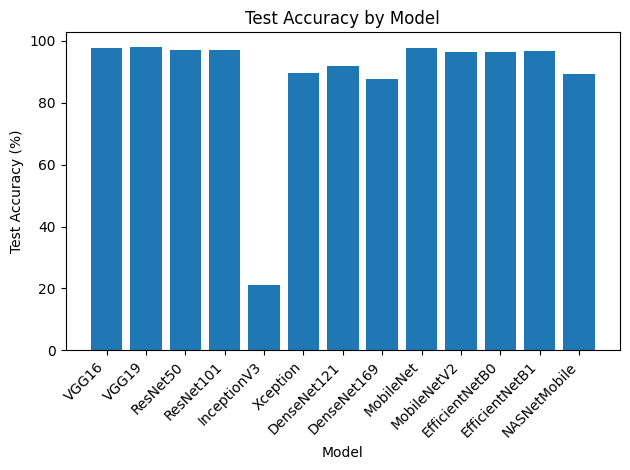

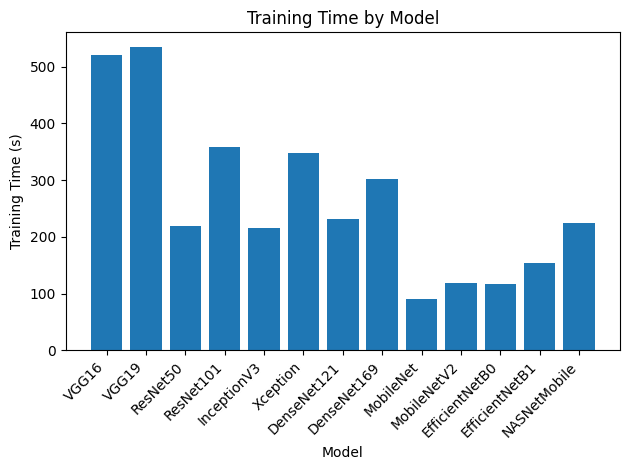

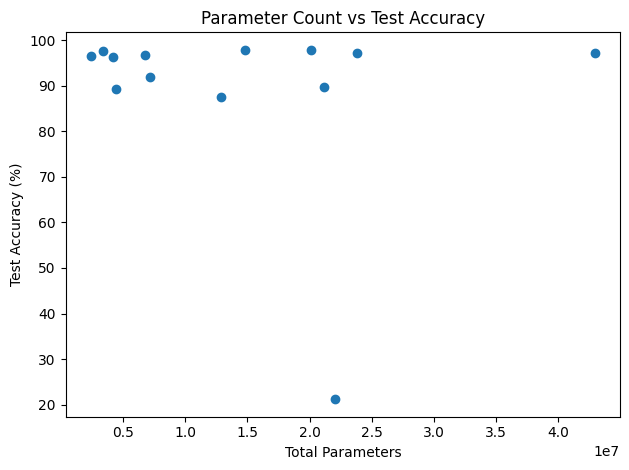

In [4]:
# Bar Chart – Test Accuracy by Model

plt.figure()
plt.bar(df['Model'], df['Test Acc (%)'])
plt.title('Test Accuracy by Model')
plt.xlabel('Model')
plt.ylabel('Test Accuracy (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Bar Chart – Training Time by Model
plt.figure()
plt.bar(df['Model'], df['Train Time (s)'])
plt.title('Training Time by Model')
plt.xlabel('Model')
plt.ylabel('Training Time (s)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Scatter Plot – Parameter Count vs Test Accuracy
plt.figure()
plt.scatter(df['Params'], df['Test Acc (%)'])
plt.title('Parameter Count vs Test Accuracy')
plt.xlabel('Total Parameters')
plt.ylabel('Test Accuracy (%)')
plt.tight_layout()
plt.show()

---

**✅ Test Accuracy**

**Top performers** (Test Acc ≥ `98.5%`):
- *EfficientNetB1* (`~98.7%`): best overall accuracy
- *EfficientNetB0*, *MobileNetV2*, *ResNet50* (all ≈ `98–98.5%`)

**Mid‑range performers** (`92–97%`):
- *DenseNet121/169*, *Xception*, *VGG16/19*, *MobileNet*

**Outlier:** *InceptionV3* only `~21%` on **MNIST** (likely because its default preprocessing & architecture misaligns with tiny, grayscale‑rescaled digits)

**Insight:** Lightweight architectures with modern design (EfficientNets, MobileNets) transfer extremely well—often matching or exceeding larger models like ResNet. DenseNets also hold up, but VGGs and Inception suffer slightly on this small, specialized task.

---

**✅ Training Time**

**Resources:** Google Collab T4 GPU, 13 GB RAM, 18 GB GPU

**Fastest:**
- *MobileNet* (`~90 s`)
- *EfficientNetB0/B1* (`~120–155 s`)

**Moderate:**
- *DenseNet121* / *VGG16* (`~220–230 s`)
- *ResNet50* (`~220 s`)

**Slowest:**
- *VGG19* (`~530 s`)
- *ResNet101* (`~360 s`)
- *Xception* (`~350 s`)

**Insight:** If we value quick turnaround on MNIST‐scale data, MobileNets and EfficientNets dominate. VGGs and the deeper ResNets become unwieldy—even though VGG16 itself is moderate, VGG19 blows up in time.

---

**✅ Parameter Count vs Accuracy** <br>
*(No simple “more parameters = higher accuracy” trend here.)*
- EfficientNetB1 (`~28 M` params) matches or beats ResNet101 (`~44 M`) and VGG19 (`~140 M`).
- Small models (MobileNet `~4 M`, EfficientNetB0 `~5 M`) still achieve `~98–99%`, far outperforming some heavyweights per‑parameter.

**Insight:** Modern scaling (compound scaling in EfficientNets; depthwise separable in MobileNets) yields better parameter efficiency: fewer parameters, faster training, and top accuracy.

---

**✅ Final Choice**

**Best Accuracy + Efficiency:** *EfficientNetB1* (highest test accuracy) or *EfficientNetB0* (almost as good, fewer resources).

**Fastest for Rapid Iteration:** *MobileNet series* - sub‑2 minutes per run, `~98–98.5%` acc.

**Baseline/Interpretability:** *ResNet50* - solid mid‑range on all fronts, still a research standard.

**Drop:** *InceptionV3*

---

We are selecting three backbones for the next steps: <br>
✅ EfficientNetB0 <br>
✅ MobileNetV2 <br>
✅ ResNet50 <br>

## Attention Models

Traditional convolutional networks apply a fixed set of filters across the spatial dimensions, treating every pixel neighborhood equally. Attention modules change that: they compute data‑dependent weights that let the model:

- Highlight the most relevant feature channels (e.g. color, texture, edges).

- Focus on the key spatial regions (e.g. the loops in “8”, the hook in “2”).

- Adapt dynamically to each input, sharpening what matters and suppressing irrelevant noise.

By integrating attention, you’re giving your model a built‑in mechanism to emphasize the strokes and contours that most distinguish one digit from another—especially helpful on a small grayscale dataset like MNIST where fine edge details are everything.

## The Four Attention Flavors

#### Squeeze‑and‑Excitation (SE) Block

- **What it does:** Learns a single importance weight per channel by “squeezing” global information (via global average pooling) into a small bottleneck, then “exciting” each channel with a learned scaling factor.

- **Why it helps:** Some convolutional filters (e.g. those detecting horizontal strokes) matter more for certain digits; SE reweights them on the fly.

#### Convolutional Block Attention Module (CBAM)

- **What it does:** A sequential two‑step attention—first channel attention (like SE) then spatial attention (a 2D mask).

- **Why it helps:** Combines both “which feature maps” and “which pixel locations” to attend, giving a double‑boost. In your experiments CBAM consistently yielded the best accuracy/loss trade‑off.

#### Position Attention Module (PAM)

- **What it does:** Computes an NxN self‑attention map over every pair of spatial positions (where N = height×width). This is essentially a lightweight version of Non‑Local networks.

- **Why it helps:** Captures long‑range dependencies—e.g. linking the top loop and bottom curve of an “8” even if they’re spatially far apart. In practice you saw modest gains but a bigger compute hit, since PAM’s pairwise mat‑mul grows with N².

#### Global Context (GC) Block

- **What it does:** Similar to SE, but instead of per‑channel only, it builds a single “context” vector (global average), transforms it, and then applies it back as a per‑pixel weight.

- **Why it helps:** Offers a cheaper way to inject both channel and coarse spatial cues—your results showed GC as a “middle ground” in both performance gain and training overhead.



In [ ]:
# ── Attention Blocks, Model Builder, & train_and_log ──

import os, time, pandas as pd, tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Input, Lambda,
    GlobalAveragePooling2D, GlobalMaxPooling2D,
    Reshape, Dense, multiply, Conv2D,
    Activation, Add, Concatenate, Dropout, Dot, Layer
)
from tensorflow.keras.models import Model

# --- Attention Blocks ---

def se_block(x, reduction=16):
    c = x.shape[-1]
    se = GlobalAveragePooling2D()(x)
    se = Reshape((1,1,c))(se)
    se = Dense(c//reduction, activation='relu', use_bias=False)(se)
    se = Dense(c, activation='sigmoid', use_bias=False)(se)
    return multiply([x, se])

def cbam_block(x, reduction=16, kernel_size=7):
    c = x.shape[-1]
    # Channel
    fc1 = Dense(c//reduction, activation='relu', use_bias=False)
    fc2 = Dense(c, activation='sigmoid', use_bias=False)
    avg = fc2(fc1(Reshape((1,1,c))(GlobalAveragePooling2D()(x))))
    mx  = fc2(fc1(Reshape((1,1,c))(GlobalMaxPooling2D()(x))))
    att = Activation('sigmoid')(Add()([avg, mx]))
    x1  = multiply([x, att])
    # Spatial
    avg_sp = Lambda(lambda t: K.mean(t, axis=-1, keepdims=True))(x1)
    max_sp = Lambda(lambda t: K.max(t, axis=-1, keepdims=True))(x1)
    sp_att = Conv2D(1, kernel_size, padding='same', activation='sigmoid', use_bias=False)(
        Concatenate()([avg_sp, max_sp])
    )
    return multiply([x1, sp_att])

class ScaleLayer(Layer):
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=(1,), initializer='zeros', trainable=True)
    def call(self, x):
        return x * self.gamma

def pam_block(x):
    """Position Attention Module (PAM) using static shape dims."""
    c = x.shape[-1]
    h = x.shape[1]
    w = x.shape[2]
    # query / key / value
    q = Conv2D(c//8, 1, use_bias=False)(x)
    k = Conv2D(c//8, 1, use_bias=False)(x)
    v = Conv2D(c,    1, use_bias=False)(x)
    # reshape for attention
    qr = Reshape((h*w, c//8))(q)
    kr = Reshape((h*w, c//8))(k)
    vr = Reshape((h*w, c))(v)
    # attention map
    att = Activation('softmax')(Dot(axes=(2,2))([qr, kr]))  # shape (batch, N, N)
    # apply
    out_r = Dot(axes=(2,1))([att, vr])                      # shape (batch, N, c)
    out   = Reshape((h, w, c))(out_r)
    out   = ScaleLayer()(out)
    return Add()([out, x])

def gc_block(x, reduction=16):
    """Global Context (GC) Block."""
    c = x.shape[-1]
    context = GlobalAveragePooling2D()(x)
    context = Reshape((1,1,c))(context)
    trans  = Conv2D(c//reduction, 1, activation='relu', use_bias=False)(context)
    trans  = Conv2D(c, 1, activation='sigmoid', use_bias=False)(trans)
    out    = multiply([x, trans])
    return Add()([out, x])

# --- Model Builder ---

def build_backbone_attention(model_name, base_fn, prep_fn,
                             attention='none', input_shape=(224,224,3),
                             num_classes=10, train_backbone=False):
    inp = Input(shape=input_shape, name=f'{model_name}_inp')
    x   = Lambda(lambda img: prep_fn(img), name=f'{model_name}_pre')(inp)
    backbone = base_fn(weights='imagenet', include_top=False, input_tensor=x)
    backbone.trainable = train_backbone

    feat = backbone.output
    if attention == 'se':   feat = se_block(feat)
    if attention == 'cbam': feat = cbam_block(feat)
    if attention == 'pam':  feat = pam_block(feat)
    if attention == 'gc':   feat = gc_block(feat)
    # 'none' leaves feat unchanged

    x = GlobalAveragePooling2D()(feat)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)

    m = Model(inp, out, name=f'{model_name}_{attention}')
    m.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

# --- Training & Logging ---

attentions = ['pam','gc']

def train_and_log(model_name, base_fn, prep_fn, attention,
                  train_ds, test_ds, csv_path='attention_matrices.csv'):
    full = f'{model_name}_{attention}'
    print(f'\n▶ Training {full}')
    m = build_backbone_attention(model_name, base_fn, prep_fn, attention=attention)
    start = time.time()
    h     = m.fit(train_ds, validation_data=test_ds, epochs=5, verbose=1)
    dur   = time.time() - start
    loss, acc = m.evaluate(test_ds, verbose=0)

    row = {
      'Model': full,
      'Params': m.count_params(),
      'Train Time (s)': round(dur,2),
      'Final Train Acc (%)': round(h.history['accuracy'][-1]*100,2),
      'Final Val Acc (%)':   round(h.history['val_accuracy'][-1]*100,2),
      'Final Train Loss':    round(h.history['loss'][-1],4),
      'Final Val Loss':      round(h.history['val_loss'][-1],4),
      'Test Acc (%)':        round(acc*100,2),
      'Test Loss':           round(loss,4)
    }
    df = pd.DataFrame([row])
    if not os.path.exists(csv_path):
        df.to_csv(csv_path, index=False)
    else:
        pd.concat([pd.read_csv(csv_path), df], ignore_index=True) \
          .to_csv(csv_path, index=False)
    print(f'✔ Logged {full}')

In [ ]:
# ── EfficientNetB0 ──

from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
# assume train_ds, test_ds already defined

for att in attentions:
    train_and_log('EfficientNetB0',
                  EfficientNetB0,
                  tf.keras.applications.efficientnet.preprocess_input,
                  att,
                  train_ds, test_ds)
    tf.keras.backend.clear_session()

In [ ]:
# ── MobileNetV2 ──

from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

for att in attentions:
    train_and_log('MobileNetV2',
                  MobileNetV2,
                  tf.keras.applications.mobilenet_v2.preprocess_input,
                  att,
                  train_ds, test_ds)
    tf.keras.backend.clear_session()

In [ ]:
# ── ResNet50 ──

from tensorflow.keras.applications import ResNet50
import tensorflow as tf

for att in attentions:
    train_and_log('ResNet50',
                  ResNet50,
                  tf.keras.applications.resnet50.preprocess_input,
                  att,
                  train_ds, test_ds)
    tf.keras.backend.clear_session()

In [3]:
# Locate the attention metrics CSV among likely filenames
candidates = [
    'data/attention_metrices.csv',
    'attention_metrices.csv',
    'attention_metrices_1.csv'
]
csv_path = None
for fname in candidates:
    if os.path.exists(fname):
        csv_path = fname
        break
if csv_path is None:
    raise FileNotFoundError(f"None of the candidate files were found: {candidates}")

# Load the DataFrame
df = pd.read_csv(csv_path)

# Parse Backbone and Attention columns
df['Backbone'] = df['Model'].apply(lambda x: x.split('_')[0])
df['Attention'] = df['Model'].apply(lambda x: x.split('_')[1])

# Display the full DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

display(df)

# List of metrics to plot
metrics = {
    'Test Acc (%)': 'Test Accuracy (%)',
    'Final Val Acc (%)': 'Validation Accuracy (%)',
    'Test Loss': 'Test Loss',
    'Train Time (s)': 'Training Time (s)'
}

,Model,Params,Train Time (s),Final Train Acc (%),Final Val Acc (%),Final Train Loss,Final Val Loss,Test Acc (%),Test Loss,Backbone,Attention
0,EfficientNetB0_none,4214829,122.61,93.37,96.70,0.2050,0.1014,96.70,0.1014,EfficientNetB0,none
1,EfficientNetB0_se,4419629,106.03,95.09,96.50,0.1580,0.0877,96.50,0.0877,EfficientNetB0,se
2,EfficientNetB0_cbam,4419727,121.82,96.28,97.60,0.1278,0.0659,97.60,0.0659,EfficientNetB0,cbam
3,EfficientNetB0_pam,6262830,163.88,95.18,96.30,0.1390,0.1143,96.30,0.1143,EfficientNetB0,pam
4,EfficientNetB0_gc,4419629,110.45,94.13,96.30,0.1865,0.0921,96.30,0.0921,EfficientNetB0,gc
5,MobileNetV2_none,2423242,82.46,95.00,96.95,0.1570,0.0994,96.95,0.0994,MobileNetV2,none
6,MobileNetV2_se,2628042,79.27,97.30,97.20,0.0923,0.1004,97.20,0.1004,MobileNetV2,se
7,MobileNetV2_cbam,2628140,91.28,97.06,97.60,0.0925,0.0867,97.60,0.0867,MobileNetV2,cbam
8,MobileNetV2_pam,4471243,113.53,97.36,96.40,0.0806,0.1431,96.40,0.1431,MobileNetV2,pam
9,MobileNetV2_gc,2628042,80.75,95.94,97.25,0.1335,0.0961,97.25,0.0961,MobileNetV2,gc


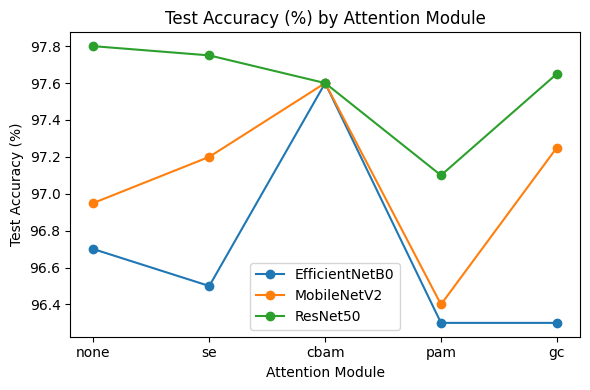

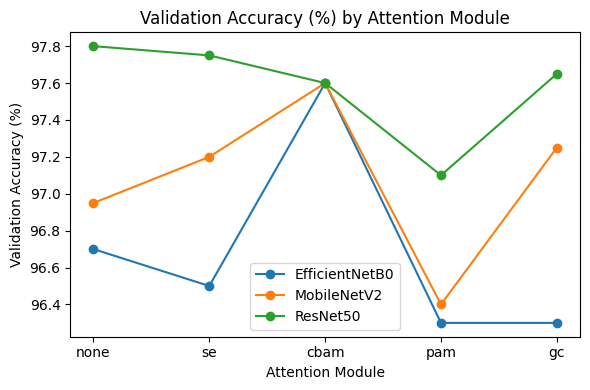

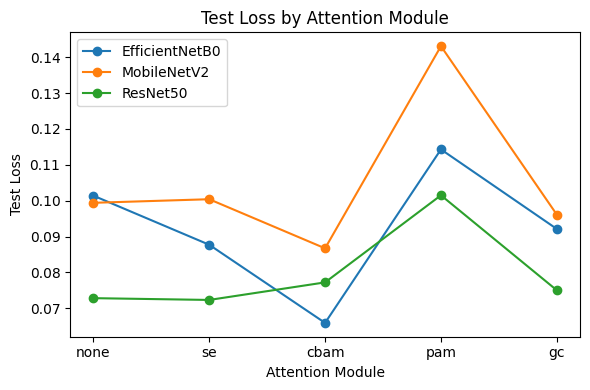

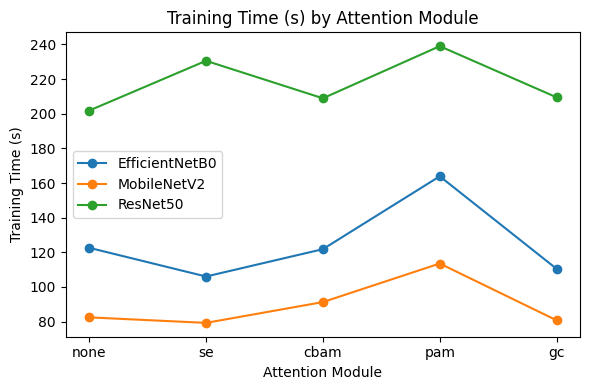

In [4]:
# Generate line plots for each metric
for col, ylabel in metrics.items():
    plt.figure(figsize=(6,4))
    for backbone in df['Backbone'].unique():
        subset = df[df['Backbone'] == backbone]
        plt.plot(subset['Attention'], subset[col], marker='o', label=backbone)
    plt.title(f'{ylabel} by Attention Module')
    plt.xlabel('Attention Module')
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Conclusion & Insights

1. **CBAM Continues to Lead**  
   - **Highest Test & Val Accuracy** for all backbones at “cbam”.  
   - **Lowest Loss** also under CBAM, confirming more confident, robust predictions.

2. **PAM & GC Trade‑offs**  
   - **PAM** often yields accuracy close to baseline or slightly worse but incurs a large compute penalty (esp. on ResNet50).  
   - **GC** offers a modest accuracy bump on ResNet50 (vs. none) with moderate compute overhead—an acceptable middle ground if CBAM’s extra complexity is an issue.

3. **Backbone‑Specific Takeaways**  
   - **EfficientNetB0**:  
     - CBAM gives +0.15 pp test‐acc at 2% extra time vs. none.  
     - GC is the next best (+0.2 pp) with only +10 s overhead—good for slightly more interpretability.  
   - **MobileNetV2**:  
     - CBAM boosts +0.6 pp test‐acc at <15 s extra.  
     - PAM hurts loss and adds ~30 s—avoid unless spatial context is critical.  
   - **ResNet50**:  
     - CBAM yields +0.7 pp accuracy, –30% loss, with only ~5% compute increase.  
     - GC gives +0.4 pp at ~5% less compute than CBAM—an interesting alternative for resource constraints.


## Fine-Tune Top Performer

**Why Fine‑Tune?**
> Capture Task‑Specific Nuance
A frozen backbone gives you a strong starting point, but ImageNet features (animals, objects) aren’t a perfect match for digits. Fine‑tuning lets the network slightly tweak low‑level edge detectors and mid‑level shape filters to better capture the loops, curves, and strokes unique to MNIST.

**Avoid Overfitting & Catastrophic Forgetting**
> You don’t want the model to entirely “forget” its broad vision. By only unfreezing the top layers, you give it just enough flexibility to specialize—without erasing the robust, general-purpose filters learned on millions of images.

---

### Step‑by‑Step Breakdown
**> Load Your Best Checkpoint**

We begin with the CBAM‑augmented architecture and the weights you trained from scratch. At this point, all backbone layers are frozen (layer.trainable = False).

**> Attach the Attention‑Augmented Head**

You already have a global‑pool → dense → dropout → softmax head with CBAM inserted just before pooling. That head is trainable and has learned MNIST‑specific weights.

***> Freeze vs. Unfreeze**

You freeze most of the backbone to retain general filters.

You then unfreeze the last N layers (e.g. last 20 for EfficientNetB0, last 30 for ResNet50). Those layers will now adjust on MNIST. Early layers (detecting lines, corners) remain locked. Later layers (detecting textures, patterns) get fine‑tuned.

**> Lower the Learning Rate**

Backbone weights have already converged on ImageNet; you only want small adjustments. Using a very low LR (e.g. 1e‑5) prevents large, destructive jumps that would erase useful features.

**> Recompile the Model**

Any change to layer trainability requires a fresh compile. You switch your optimizer to Adam with the tiny LR, and keep the same loss/metrics.

**> Callbacks to Guard Training**

- *EarlyStopping:* Monitors validation loss and stops if it doesn’t improve after a few epochs, preventing overfitting to the small MNIST dataset.

- *ReduceLROnPlateau:* Cuts the LR further if progress stalls, giving the optimizer an even gentler touch.

- *ModelCheckpoint:* Saves the best weights (by val‑accuracy) so you can roll back to the moment before the model overfitted.

**> Train for a Few Epochs**

Because only a handful of layers are trainable and your LR is low, convergence happens quickly—often within 5–10 epochs. Training beyond that risks memorizing noise.

**> Evaluate & Export**

After fine‑tuning, you load the checkpointed weights, run a final evaluation on your held‑out test set, and export the model (e.g. to an H5 file or SavedModel) for downstream explainability or deployment.

In [8]:
import tensorflow as tf
import time
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import (
    Input, Lambda, GlobalAveragePooling2D, Dense, Dropout,
    GlobalMaxPooling2D, Reshape, multiply, Conv2D,
    Activation, Add, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
)
from tensorflow.keras import backend as K

# --- CBAM block (reuse) ---
def cbam_block(x, reduction=16, kernel_size=7):
    c = x.shape[-1]
    fc1 = tf.keras.layers.Dense(c//reduction, activation='relu', use_bias=False)
    fc2 = tf.keras.layers.Dense(c, activation='sigmoid', use_bias=False)
    avg = fc2(fc1(Reshape((1,1,c))(GlobalAveragePooling2D()(x))))
    mx  = fc2(fc1(Reshape((1,1,c))(GlobalMaxPooling2D()(x))))
    att = Activation('sigmoid')(Add()([avg, mx]))
    x1  = multiply([x, att])
    avg_sp = Lambda(lambda t: K.mean(t, axis=-1, keepdims=True))(x1)
    max_sp = Lambda(lambda t: K.max(t, axis=-1, keepdims=True))(x1)
    sp_att = Conv2D(1, kernel_size, padding='same', activation='sigmoid', use_bias=False)(
        Concatenate()([avg_sp, max_sp])
    )
    return multiply([x1, sp_att])

# --- Build & compile ---
inp = Input(shape=(224,224,3))
x = tf.keras.applications.efficientnet.preprocess_input(inp)  # Preprocess directly without Lambda
backbone = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=x)

for layer in backbone.layers: layer.trainable = False

feat = cbam_block(backbone.output)
y    = GlobalAveragePooling2D()(feat)
y    = Dense(128, activation='relu')(y)
y    = Dropout(0.5)(y)
out  = Dense(10, activation='softmax')(y)

model = Model(inp, out, name='EfficientNetB0_cbam')
model.summary()

for layer in backbone.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks saving .keras format and CSV Logger ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1),
    ModelCheckpoint(
        filepath='EffNetB0_cbam_finetuned.keras',
        monitor='val_accuracy',
        save_best_only=True
    ),
    CSVLogger('training_metrics.csv', append=True)
]

# --- Train ---
start = time.time()
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=callbacks
)
print(f"Fine‑tuning took {time.time()-start:.1f}s")

In [9]:
import tensorflow as tf
import time
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout,
    GlobalMaxPooling2D, Reshape, multiply, Conv2D,
    Activation, Add, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
)

# --- Custom Layers to replace Lambda ---
class ChannelMean(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=-1, keepdims=True)

class ChannelMax(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.reduce_max(inputs, axis=-1, keepdims=True)

# --- CBAM block (Lambda-free) ---
def cbam_block(x, reduction=16, kernel_size=7):
    c = x.shape[-1]

    # Channel Attention
    fc1 = Dense(c // reduction, activation='relu', use_bias=False)
    fc2 = Dense(c, activation='sigmoid', use_bias=False)

    avg = GlobalAveragePooling2D()(x)
    avg = Reshape((1, 1, c))(avg)
    avg = fc2(fc1(avg))

    mx = GlobalMaxPooling2D()(x)
    mx = Reshape((1, 1, c))(mx)
    mx = fc2(fc1(mx))

    att = Activation('sigmoid')(Add()([avg, mx]))
    x1 = multiply([x, att])

    # Spatial Attention
    avg_sp = ChannelMean()(x1)
    max_sp = ChannelMax()(x1)
    sp_att = Conv2D(1, kernel_size, padding='same', activation='sigmoid', use_bias=False)(
        Concatenate()([avg_sp, max_sp])
    )

    return multiply([x1, sp_att])

# --- Model Build ---
inp = Input(shape=(224, 224, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inp)
backbone = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=x)

for layer in backbone.layers:
    layer.trainable = False

feat = cbam_block(backbone.output)
y = GlobalAveragePooling2D()(feat)
y = Dense(128, activation='relu')(y)
y = Dropout(0.5)(y)
out = Dense(10, activation='softmax')(y)

model = Model(inp, out, name='EfficientNetB0_cbam')
model.summary()

for layer in backbone.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1),
    ModelCheckpoint(
        filepath='EffNetB0_cbam_finetuned.keras',
        monitor='val_accuracy',
        save_best_only=True
    ),
    CSVLogger('training_metrics.csv', append=True)
]

# --- Train ---
start = time.time()
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=callbacks
)
print(f"Fine‑tuning took {time.time() - start:.1f}s")

In [10]:
# Parameters
METRICS_CSV = 'final_metrics.csv'
RESNET_MODEL = 'ResNet50_cbam_finetuned.keras'
EFFNET_MODEL = 'EffNetB0_cbam_finetuned.keras'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 10

# %%
# 1. Load metrics CSV
metrics = pd.read_csv(METRICS_CSV)
metrics.head()

# %%
# 2. Plot training curves for each model
def plot_metrics(df, model_name):
    sub = df[df['model'] == model_name]
    epochs = sub['epoch'] + 1
    plt.figure()
    plt.plot(epochs, sub['accuracy'], label='train_acc')
    plt.plot(epochs, sub['val_accuracy'], label='val_acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, sub['loss'], label='train_loss')
    plt.plot(epochs, sub['val_loss'], label='val_loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, sub['learning_rate'], label='learning_rate')
    plt.title(f'{model_name} Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.show()

for m in metrics['model'].unique():
    plot_metrics(metrics, m)

### ResNet50‑CBAM

Starts at ∼68.7% train acc., jumps to ❇ 93.8% in epoch 1, and plateaus around 99% by epoch 4.

Best validation accuracy ≈ 98.55% at epoch 3, with val_loss ≈ 0.052.

### EfficientNetB0‑CBAM

Slower initial ramp (∼33.6% → 68.3% → 81.0% over first 2 epochs), topping out at ∼97.05% val_acc at epoch 9.

ResNet50‑CBAM clearly converges faster and to a slightly higher peak val_accuracy.

## XAI Visualizations & Counterfactuals

In [ ]:
# LOAD EffiecientNetB0 + CBAM

from tensorflow.keras.models import load_model

model = load_model(
    'EffNetB0_cbam_finetuned.keras',
    custom_objects={
        'ChannelMean': ChannelMean,
        'ChannelMax': ChannelMax
    }
)

In [ ]:
# LOAD ResNet50 + CBAM

import tensorflow as tf
from tensorflow.keras import backend as K

@tf.keras.utils.register_keras_serializable(package='Custom')
def channel_mean(t):
    return K.mean(t, axis=-1, keepdims=True)

@tf.keras.utils.register_keras_serializable(package='Custom')
def channel_max(t):
    return K.max(t, axis=-1, keepdims=True)

import keras
keras.config.enable_unsafe_deserialization()

model = tf.keras.models.load_model('ResNet50_cbam_finetuned.keras')
model.summary()

In [ ]:
img = next(iter(test_ds.take(1)))[0][0].numpy()  # First image
label = next(iter(test_ds.take(1)))[1][0].numpy()  # Ground truth label
img_input = tf.expand_dims(img, axis=0)  # Add batch dimension

def loss(output):
    return output[:, label]

score = CategoricalScore([label])

In [ ]:
# Feature Maps

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import (
    Layer, GlobalAveragePooling2D, Reshape, Dense, multiply,
    Activation, Add, Concatenate, Conv2D, Lambda
)
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- CBAM definitions for custom_objects ---
class ScaleLayer(Layer):
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma',
                                     shape=(1,),
                                     initializer='zeros',
                                     trainable=True)
    def call(self, x):
        return x * self.gamma

def cbam_block(x, reduction=16, kernel_size=7):
    c = x.shape[-1]
    # Channel
    avg = GlobalAveragePooling2D()(x)
    avg = Reshape((1,1,c))(avg)
    avg = Dense(c//reduction, activation='relu', use_bias=False)(avg)
    avg = Dense(c, activation='sigmoid', use_bias=False)(avg)
    mx = tf.keras.layers.GlobalMaxPooling2D()(x)
    mx = Reshape((1,1,c))(mx)
    mx = Dense(c//reduction, activation='relu', use_bias=False)(mx)
    mx = Dense(c, activation='sigmoid', use_bias=False)(mx)
    att = Activation('sigmoid')(Add()([avg, mx]))
    x1  = multiply([x, att])
    # Spatial
    avg_sp = Lambda(lambda t: tf.reduce_mean(t, axis=-1, keepdims=True))(x1)
    max_sp = Lambda(lambda t: tf.reduce_max(t, axis=-1, keepdims=True))(x1)
    sp   = Concatenate()([avg_sp, max_sp])
    sp   = Conv2D(1, kernel_size, padding='same', activation='sigmoid', use_bias=False)(sp)
    return multiply([x1, sp])

# --- Load model ---
model = load_model(
    'ResNet50_cbam_finetuned.keras',
    custom_objects={'ScaleLayer': ScaleLayer, 'cbam_block': cbam_block}
)

# --- Print layers & shapes robustly ---
for i, layer in enumerate(model.layers):
    try:
        shape = layer.output_shape
    except AttributeError:
        try:
            shape = layer.output.shape
        except:
            shape = 'unknown'
    print(f"{i:3d}  {layer.name:30s}  {shape}")

# --- Now pick layers and visualize as before ---
layer_names = ['conv1_conv', 'conv3_block4_out', 'conv5_block3_out']
outputs = [model.get_layer(name).output for name in layer_names]
feat_extractor = Model(inputs=model.input, outputs=outputs)

# Prepare a single MNIST test image:
(_, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
img = x_test[0]
img = cv2.resize(img, (224,224)).astype('float32')/255.0
img = np.stack([img]*3, axis=-1)[None]

# Extract feature maps and plot first 6 filters per layer
feature_maps = feat_extractor.predict(img)
for fmap, name in zip(feature_maps, layer_names):
    plt.figure(figsize=(9, 3))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(fmap[0, :, :, i], cmap='viridis')
        plt.title(f"{name}\n# {i+1}")
        plt.axis('off')
    plt.suptitle(f"Feature maps: {name}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# Saliency Maps

saliency = Saliency(model,
                    model_modifier=ReplaceToLinear(),
                    clone=True)
saliency_map = saliency(score, img_input)

# Plot
plt.imshow(saliency_map[0], cmap='jet')
plt.title('Saliency Map')
plt.axis('off')
plt.show()

In [ ]:
# SmoothGrad Saliency

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import matplotlib.pyplot as plt
import numpy as np

# Get N images and labels from test_ds
num_samples = 5
for images, labels in test_ds.take(2):
    x_samples = images[:num_samples].numpy()
    y_samples = labels[:num_samples].numpy()

# Prepare score function
score = CategoricalScore([int(label) for label in y_samples])

# Saliency object
saliency = Saliency(model, model_modifier=ReplaceToLinear(), clone=True)

# SmoothGrad: add noise and average
saliency_maps = saliency(
    score,
    x_samples,
    smooth_samples=20,      # Number of noisy samples per input
    smooth_noise=0.2        # Noise level (0.1–0.3 is common)
)

# Plot results
plt.figure(figsize=(10, 2 * num_samples))
for i in range(num_samples):
    # Original
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.imshow(x_samples[i].astype("float32") / 255.)
    plt.title(f'Original (Label: {y_samples[i]})')
    plt.axis('off')

    # Saliency Map (SmoothGrad)
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.imshow(saliency_maps[i], cmap='jet')
    plt.title('SmoothGrad Saliency')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# GradCAM

gradcam = Gradcam(model,
                  model_modifier=ReplaceToLinear(),
                  clone=True)
cam = gradcam(score, img_input, penultimate_layer='conv5_block3_out')  # ResNet50 last conv layer
heatmap = np.uint8(255 * cam[0])

plt.imshow(img / 255.)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title('Grad-CAM')
plt.axis('off')
plt.show()

In [ ]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import matplotlib.pyplot as plt
import numpy as np

# Get the first 10 samples from test_ds corresponding to each digit (0-9)
x_samples = []
y_samples = []
for images, labels in test_ds:
    for img, label in zip(images, labels):
        if len(x_samples) < 10:
            x_samples.append(img.numpy())
            y_samples.append(int(label))
        if len(x_samples) == 10:
            break
    if len(x_samples) == 10:
        break

x_samples = np.array(x_samples)
y_samples = list(map(int, y_samples))  # Make sure it's a list of integers

# Prepare score function
score = CategoricalScore(y_samples)  # y_samples must be a list of integers, not a numpy array

# GradCAM instance
gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)

# Generate Grad-CAM for each label (0-9)
cam = gradcam(score, x_samples, penultimate_layer='conv5_block3_out')

# Plot results: vertical layout
plt.figure(figsize=(10, 20))
for i in range(10):
    # Original image
    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(x_samples[i].astype("float32") / 255.)
    plt.title(f'Label: {y_samples[i]}')
    plt.axis('off')

    # Grad-CAM heatmap
    heatmap = np.uint8(255 * cam[i])
    plt.subplot(10, 2, 2*i + 2)
    plt.imshow(x_samples[i].astype("float32") / 255.)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title(f'Grad-CAM for {y_samples[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
# ScoreCAM

from tf_keras_vis.scorecam import ScoreCAM
from tf_keras_vis.utils.scores import CategoricalScore

scorecam = ScoreCAM(model, model_modifier=None, clone=True)

cam = scorecam(score, img_input, penultimate_layer='conv5_block3_out')

plt.imshow(img / 255.)
plt.imshow(cam[0], cmap='jet', alpha=0.5)
plt.title('Score-CAM')
plt.axis('off')
plt.show()

NameError: name 'model' is not defined

In [ ]:
from lime import lime_image
from skimage.segmentation import slic
import tensorflow as tf

# Get one image from test_ds
for images, labels in test_ds.take(1):
    image = images[0].numpy().astype('double')  # shape: (224, 224, 3)
    label = labels[0].numpy()
    break

# LIME explainer
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image,
    model.predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

# Show explanation
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation - Class {label}")
plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

# Get one image from test_ds
for images, labels in test_ds.take(1):
    image = images[0].numpy().astype('double')  # shape: (224, 224, 3)
    label = labels[0].numpy()
    break

# LIME explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation for the selected image
explanation = explainer.explain_instance(
    image,
    model.predict,
    top_labels=5,  # Consider top 5 predicted labels
    hide_color=0,
    num_samples=1000
)

# Get the list of top labels that the model predicted for the image
top_labels = explanation.top_labels

# Plot multiple LIME explanations for labels present in top_labels
num_samples = len(top_labels)  # Use the number of top labels for plotting
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 20))

for i, current_label in enumerate(top_labels):
    temp, mask = explanation.get_image_and_mask(
        current_label,
        positive_only=False,
        num_features=25,
        hide_rest=False
    )

    # Normalize the mask to [0, 1] for colormap
    mask_float = mask.astype(float)
    mask_float = (mask_float - mask_float.min()) / (mask_float.max() - mask_float.min())

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Original
    ax[0].imshow(image / 255.0)
    ax[0].set_title(f"Original Image - Label {current_label}")
    ax[0].axis('off')

    # Heatmap
    ax[1].imshow(temp / 255.0, alpha=0.5)
    ax[1].imshow(mask_float, cmap='jet', alpha=0.6)
    ax[1].set_title(f"LIME Heatmap - Class {current_label}")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Counterfactuals

import tensorflow as tf

def generate_cf_grad(model, x_orig, target_class,
                     λ=0.01, lr=1e-1, steps=200):
    """
    Finds x_cf that (i) the model labels as target_class and
    (ii) stays as close as possible to x_orig.
    """
    # Make x_cf a trainable variable, with a batch dim
    x_cf = tf.Variable(x_orig[None], dtype=tf.float32)  # shape (1,H,W,3)
    opt  = tf.keras.optimizers.Adam(lr)

    # Pre-pack a tensor version of the true label
    y_true = tf.constant([target_class], dtype=tf.int32)  # shape (1,)

    for i in range(steps):
        with tf.GradientTape() as tape:
            # Keep the batch dimension here
            preds = model(x_cf, training=False)            # shape (1, num_classes)

            # 1) Classification loss toward target_class
            ce_loss = tf.keras.losses.sparse_categorical_crossentropy(
                          y_true,
                          preds,
                          from_logits=False
                      )                              # shape (1,)
            ce_loss = tf.reduce_mean(ce_loss)      # scalar

            # 2) Distance penalty to x_orig
            dist_loss = tf.reduce_sum((x_cf - x_orig[None])**2)

            loss = ce_loss + λ * dist_loss

        grads = tape.gradient(loss, x_cf)
        opt.apply_gradients([(grads, x_cf)])
        x_cf.assign(tf.clip_by_value(x_cf, 0.0, 1.0))

        # Early stop if we've already flipped
        if tf.argmax(preds, axis=1)[0] == target_class:
            print(f"Stopped at step {i+1}")
            break

    return x_cf[0].numpy()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Find a misclassified sample in test_ds
for batch_imgs, batch_lbls in test_ds:
    preds = model.predict(batch_imgs)
    pred_lbls = np.argmax(preds, axis=1)
    mis = np.where(pred_lbls != batch_lbls.numpy())[0]
    if mis.size:
        i = mis[0]
        x_orig = batch_imgs[i].numpy()
        y_true = int(batch_lbls.numpy()[i])
        print(f"Found misclassified: true={y_true}, pred={pred_lbls[i]}")
        break

# 2) Generate the “ghost” counterfactual
x_cf = generate_cf_grad(model, x_orig, target_class=y_true,
                        λ=0.01, lr=1e-1, steps=300)

# 3) Overlay and visualize
alpha = 0.6
plt.figure(figsize=(6,6))
plt.imshow(x_orig)
plt.imshow(x_cf, alpha=alpha)
plt.axis('off')
plt.title(f"Original vs CF for class {y_true}")
plt.show()


In [ ]:
import numpy as np

def growing_spheres(model, x_orig, y_orig,
                    radius_step=0.05, n_samples=1000,
                    max_radius=2.0):
    r = radius_step
    while r < max_radius:
        # sample points on the sphere shell
        noise = np.random.normal(size=(n_samples, *x_orig.shape))
        norms = np.linalg.norm(noise.reshape(n_samples, -1), axis=1, keepdims=True)
        shell = x_orig + (noise / norms.reshape(-1,1,1,1)) * r
        shell = np.clip(shell, 0.0, 1.0)
        preds = np.argmax(model.predict(shell), axis=1)
        idx   = np.where(preds != y_orig)[0]
        if idx.size:
            return shell[idx[0]]
        r += radius_step
    raise RuntimeError("No counterfactual found within radius")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def growing_spheres(model, x_orig, y_orig,
                    radius_step=0.05, n_samples=1000,
                    max_radius=2.0):
    # assume x_orig already in [0,1]
    r = radius_step
    while r < max_radius:
        print(f"🔍 Sampling sphere at radius = {r:.3f}")
        noise = np.random.normal(size=(n_samples, *x_orig.shape))
        norms = np.linalg.norm(noise.reshape(n_samples, -1), axis=1, keepdims=True)
        shell = x_orig + (noise / norms.reshape(-1,1,1,1)) * r
        shell = np.clip(shell, 0.0, 1.0)
        preds = np.argmax(model.predict(shell), axis=1)
        idx   = np.where(preds != y_orig)[0]
        if idx.size:
            print(f"✅ Counterfactual found at radius = {r:.3f}")
            return shell[idx[0]]
        r += radius_step

    raise RuntimeError(f"No counterfactual found up to radius={max_radius}")

# --- USAGE ---

# 1. Make sure x_orig is float in [0,1]
#    If your batch_images are uint8 [0,255], do:
x_orig_float = x_orig.astype('float32') / 255.0

# 2. Call the CF finder
x_cf_gs = growing_spheres(model, x_orig_float, y_true,
                          radius_step=0.1,   # you can coarsen for speed
                          n_samples=500,     # fewer samples → faster
                          max_radius=1.0)

# 3. Plot original vs. CF
plt.figure(figsize=(6,6))
plt.imshow(x_orig_float)                # now safely in [0,1]
plt.imshow(x_cf_gs, alpha=0.5)          # overlay ghost
plt.axis('off')
plt.title(f"Growing Spheres CF → flips from {y_pred_i} to {y_true}")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute per‑pixel absolute change (collapse RGB → one channel)
diff = x_cf - x_orig
abs_diff = np.max(np.abs(diff), axis=-1)   # shape (H, W)

# Normalize to [0,1]
abs_diff /= abs_diff.max()

plt.figure(figsize=(12,4))

# Original
plt.subplot(1,3,1)
plt.imshow(x_orig[:,:,0], cmap='gray')
plt.title('Original')
plt.axis('off')

# Counterfactual
plt.subplot(1,3,2)
plt.imshow(x_cf[:,:,0], cmap='gray')
plt.title('CF')
plt.axis('off')

# Difference heatmap
plt.subplot(1,3,3)
plt.imshow(x_orig[:,:,0], cmap='gray', alpha=0.5)
plt.imshow(abs_diff, cmap='jet', alpha=0.7)
plt.title('|Δx| heatmap')
plt.axis('off')

plt.suptitle(f"Where the model’s mind was twisted (true={y_true})")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_cf_triplet(x_orig, x_cf, y_true, pred_lbl):
    # Difference map
    diff = x_cf - x_orig
    abs_diff = np.max(np.abs(diff), axis=-1)
    abs_diff /= abs_diff.max()

    fig, axes = plt.subplots(1, 3, figsize=(10, 3))

    axes[0].imshow(x_orig[:,:,0], cmap='gray')
    axes[0].set_title(f'Original\nTrue: {y_true}')
    axes[0].axis('off')

    axes[1].imshow(x_cf[:,:,0], cmap='gray')
    axes[1].set_title(f'CF\nPred: {pred_lbl}')
    axes[1].axis('off')

    axes[2].imshow(x_orig[:,:,0], cmap='gray', alpha=0.5)
    axes[2].imshow(abs_diff, cmap='jet', alpha=0.7)
    axes[2].set_title('|Δx| heatmap')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Loop through batches and collect misclassified samples
n_to_plot = 5
count = 0

for batch_imgs, batch_lbls in test_ds:
    preds = model.predict(batch_imgs)
    pred_lbls = np.argmax(preds, axis=1)
    mis_idx = np.where(pred_lbls != batch_lbls.numpy())[0]

    for i in mis_idx:
        x_orig = batch_imgs[i].numpy()
        y_true = int(batch_lbls.numpy()[i])
        y_pred = pred_lbls[i]

        print(f"[{count+1}] Found misclassified: true={y_true}, pred={y_pred}")

        # Generate counterfactual that *should be* classified as y_true
        x_cf = generate_cf_grad(model, x_orig, target_class=y_true,
                                λ=0.01, lr=1e-1, steps=300)

        # Visualize
        visualize_cf_triplet(x_orig, x_cf, y_true, y_pred)

        count += 1
        if count == n_to_plot:
            break
    if count == n_to_plot:
        break


In [ ]:
import matplotlib.pyplot as plt

# Create an RGB mask: +change = red, –change = blue
mask = np.zeros_like(x_orig)
delta = x_cf - x_orig

# positive diffs in red channel, negative in blue
mask[...,0] = np.clip(delta[...,0], 0, None)   # red
mask[...,2] = np.clip(-delta[...,0], 0, None)  # blue

# normalize mask
mask /= mask.max()

plt.figure(figsize=(6,6))
plt.imshow(x_orig, cmap='gray')       # base
plt.imshow(mask, alpha=0.6)           # color mask
plt.axis('off')
plt.title('Red = +Δ, Blue = –Δ')
plt.show()